In [396]:
# Lets try simple logistic regression with no super sampling shit to see how it goes first
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, SCORERS
import matplotlib as plt
%matplotlib inline
from matplotlib import rcParams
import pandas as pd
import numpy as np
import pprint as pp



stats = pd.read_csv('stats_1.5.csv')
stats.drop(labels='Unnamed: 0', axis=1, inplace=True)
stats['MVP'] = stats['MVP'].apply(lambda x : int(x))
stats['Impact_1'] = (stats['TmWin'] * stats['G']) / 82 
stats['Impact'] = stats['Impact_1'] * ((stats['MP'] / 48) * (stats['USG%']/100))
stats.drop(labels='Impact_1', axis=1, inplace=True)

In [424]:
stats.columns

Index(['Player', 'MVP', 'Year', 'Age', 'TmWin', 'G', 'GS', 'MP', 'PER', 'TS%',
       '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%',
       'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP',
       'FG/G', 'FGA/G', 'FG%', '3P/G', '3PA/G', '3P%', '2P/G', '2PA/G', '2P%',
       'eFG%', 'FT/G', 'FTA/G', 'FT%', 'ORB/G', 'DRB/G', 'TRB/G', 'AST/G',
       'STL/G', 'BLK/G', 'TOV/G', 'PF/G', 'PPG', 'Impact'],
      dtype='object')

In [425]:
stats.to_csv(r'C:\Users\kengw\Desktop\stats_1.6.csv')

In [397]:
X = stats[['WS', 'TS%', 'PPG', 'Impact', 'PER']]
y = stats['MVP']

In [398]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
train = X_train, y_train

Accuracy : 0.9618
AUC Score : 0.763588
[[3245   79]
 [  52   54]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3324
           1       0.41      0.51      0.45       106

   micro avg       0.96      0.96      0.96      3430
   macro avg       0.70      0.74      0.72      3430
weighted avg       0.97      0.96      0.96      3430

AUC Score 0.7635875735077085
Accuracy (I.e. Total Correct Predictions / Total Predictions) 0.9728862973760933


C:\Users\kengw\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.860618       0.020694       0.835362      0.049969
1        0.912221       0.029098       0.891233      0.034568


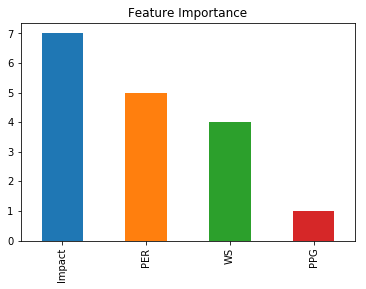

In [5]:
# Test run 1
xgb_classt1 = XGBClassifier(learning_rate=2.8, n_estimators=500, max_depth=2, min_child_weight=6,
                                                objective='binary:logistic', subsample=0.8, colsample_by_tree = 0.75,
                                                nthread=4, scale_post_weight=1, seed=27, gamma=0, reg_alpha=0.01)



xgb_classt1.fit(X_train, y_train)

predictionst1 = xgb_classt1.predict(X_test)
predict_probat1 = xgb_classt1.predict_proba(X_test)

print("Accuracy : %.4g" % accuracy_score(y_test, predictionst1))
print("AUC Score : %f" % roc_auc_score(y_test, predict_probat1[:,1]))


print(confusion_matrix(y_test, predictionst1))
print(classification_report(y_test, predictionst1))
print('AUC Score', roc_auc_score(y_test, predict_probat1[:,1]))



print('Accuracy (I.e. Total Correct Predictions / Total Predictions)', (3297 + 40) / 3430)

params = {'learning_rate':2.5, 'scale_post_weight':1, 'min_child_weight':6, 'gamma':0, 'subsample':0.8, 
          'nthread':4, 'objective':'binary:logistic', 'n_estimators':265, 'seed':27, 'colsample_bytree':0.75,
          'max_depth':2, 'reg_alpha':0.01}

train = xgb.DMatrix(X_train, y_train)

cv_results = xgb.cv(dtrain=train, params=params, nfold=5, num_boost_round=50, early_stopping_rounds=10, metrics='auc',
                    as_pandas=True, seed=123)

print(cv_results)


feat_imp = pd.Series(xgb_classt1.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importance')

In [1200]:
# Lets try to gridsearch for precision now
param_t1 = {'n_estimators':[500], 'subsample':[i/10.0 for i in range(0,10,1)], 'colsample_bytree':[i/10.0 for i in range(0,10,1)],
            'scale_post_weight':[i/10.0 for i in range(0,10,1)]}

gsearch1 = GridSearchCV(estimator=XGBClassifier(learning_rate=2.8,
                                                gamma=0.01, objective='binary:logistic',
                                                nthread=4, seed=27),
                        param_grid = param_t1, scoring='precision', n_jobs=4, iid=False, cv=5)


gsearch1.fit(X_train, y_train)


print(gsearch1.best_params_)
print(gsearch1.best_score_)
pp.pprint(gsearch1.cv_results_)


{'colsample_bytree': 0.6, 'n_estimators': 500, 'scale_post_weight': 0.0, 'subsample': 0.5}
0.3641032873480691
{'mean_fit_time': array([3.29012275, 2.54399414, 2.58069582, 2.60124054, 2.66586738,
       2.80669174, 2.69598651, 2.63554883, 2.65649242, 2.57231803,
       2.61101446, 2.56553612, 2.54578872, 2.58209157, 2.6078227 ,
       2.68362055, 2.72092032, 2.63514986, 2.62278347, 2.60004363,
       2.41852889, 2.48634796, 2.55695934, 2.62617393, 2.62417922,
       2.67703781, 2.65948496, 2.65589428, 2.62876658, 2.58947215,
       2.41015177, 2.45403409, 2.68541551, 2.69818196, 2.60622725,
       2.66666579, 2.63854094, 2.79133229, 2.7921298 , 2.55875416,
       2.44166694, 2.52823539, 2.57152038, 2.61600122, 2.64512281,
       2.7498425 , 2.68062816, 2.6680613 , 2.62876749, 2.59625444,
       2.39499183, 2.48634791, 2.57650709, 2.60203829, 2.63435163,
       2.69977665, 2.65948472, 2.65988412, 2.63495073, 2.61041636,
       2.42291803, 2.45902171, 2.57132082, 2.63475084, 2.74744959,
 

            {'colsample_bytree': 0.1,
             'n_estimators': 500,
             'scale_post_weight': 0.4,
             'subsample': 0.4},
            {'colsample_bytree': 0.1,
             'n_estimators': 500,
             'scale_post_weight': 0.4,
             'subsample': 0.5},
            {'colsample_bytree': 0.1,
             'n_estimators': 500,
             'scale_post_weight': 0.4,
             'subsample': 0.6},
            {'colsample_bytree': 0.1,
             'n_estimators': 500,
             'scale_post_weight': 0.4,
             'subsample': 0.7},
            {'colsample_bytree': 0.1,
             'n_estimators': 500,
             'scale_post_weight': 0.4,
             'subsample': 0.8},
            {'colsample_bytree': 0.1,
             'n_estimators': 500,
             'scale_post_weight': 0.4,
             'subsample': 0.9},
            {'colsample_bytree': 0.1,
             'n_estimators': 500,
             'scale_post_weight': 0.5,
             'subsample': 0.0},

             'scale_post_weight': 0.1,
             'subsample': 0.0},
            {'colsample_bytree': 0.3,
             'n_estimators': 500,
             'scale_post_weight': 0.1,
             'subsample': 0.1},
            {'colsample_bytree': 0.3,
             'n_estimators': 500,
             'scale_post_weight': 0.1,
             'subsample': 0.2},
            {'colsample_bytree': 0.3,
             'n_estimators': 500,
             'scale_post_weight': 0.1,
             'subsample': 0.3},
            {'colsample_bytree': 0.3,
             'n_estimators': 500,
             'scale_post_weight': 0.1,
             'subsample': 0.4},
            {'colsample_bytree': 0.3,
             'n_estimators': 500,
             'scale_post_weight': 0.1,
             'subsample': 0.5},
            {'colsample_bytree': 0.3,
             'n_estimators': 500,
             'scale_post_weight': 0.1,
             'subsample': 0.6},
            {'colsample_bytree': 0.3,
             'n_estimators': 500,

             'scale_post_weight': 0.2,
             'subsample': 0.1},
            {'colsample_bytree': 0.4,
             'n_estimators': 500,
             'scale_post_weight': 0.2,
             'subsample': 0.2},
            {'colsample_bytree': 0.4,
             'n_estimators': 500,
             'scale_post_weight': 0.2,
             'subsample': 0.3},
            {'colsample_bytree': 0.4,
             'n_estimators': 500,
             'scale_post_weight': 0.2,
             'subsample': 0.4},
            {'colsample_bytree': 0.4,
             'n_estimators': 500,
             'scale_post_weight': 0.2,
             'subsample': 0.5},
            {'colsample_bytree': 0.4,
             'n_estimators': 500,
             'scale_post_weight': 0.2,
             'subsample': 0.6},
            {'colsample_bytree': 0.4,
             'n_estimators': 500,
             'scale_post_weight': 0.2,
             'subsample': 0.7},
            {'colsample_bytree': 0.4,
             'n_estimators': 500,

             'subsample': 0.2},
            {'colsample_bytree': 0.5,
             'n_estimators': 500,
             'scale_post_weight': 0.3,
             'subsample': 0.3},
            {'colsample_bytree': 0.5,
             'n_estimators': 500,
             'scale_post_weight': 0.3,
             'subsample': 0.4},
            {'colsample_bytree': 0.5,
             'n_estimators': 500,
             'scale_post_weight': 0.3,
             'subsample': 0.5},
            {'colsample_bytree': 0.5,
             'n_estimators': 500,
             'scale_post_weight': 0.3,
             'subsample': 0.6},
            {'colsample_bytree': 0.5,
             'n_estimators': 500,
             'scale_post_weight': 0.3,
             'subsample': 0.7},
            {'colsample_bytree': 0.5,
             'n_estimators': 500,
             'scale_post_weight': 0.3,
             'subsample': 0.8},
            {'colsample_bytree': 0.5,
             'n_estimators': 500,
             'scale_post_weight': 0.3,

             'subsample': 0.3},
            {'colsample_bytree': 0.6,
             'n_estimators': 500,
             'scale_post_weight': 0.4,
             'subsample': 0.4},
            {'colsample_bytree': 0.6,
             'n_estimators': 500,
             'scale_post_weight': 0.4,
             'subsample': 0.5},
            {'colsample_bytree': 0.6,
             'n_estimators': 500,
             'scale_post_weight': 0.4,
             'subsample': 0.6},
            {'colsample_bytree': 0.6,
             'n_estimators': 500,
             'scale_post_weight': 0.4,
             'subsample': 0.7},
            {'colsample_bytree': 0.6,
             'n_estimators': 500,
             'scale_post_weight': 0.4,
             'subsample': 0.8},
            {'colsample_bytree': 0.6,
             'n_estimators': 500,
             'scale_post_weight': 0.4,
             'subsample': 0.9},
            {'colsample_bytree': 0.6,
             'n_estimators': 500,
             'scale_post_weight': 0.5,

             'n_estimators': 500,
             'scale_post_weight': 0.0,
             'subsample': 0.5},
            {'colsample_bytree': 0.8,
             'n_estimators': 500,
             'scale_post_weight': 0.0,
             'subsample': 0.6},
            {'colsample_bytree': 0.8,
             'n_estimators': 500,
             'scale_post_weight': 0.0,
             'subsample': 0.7},
            {'colsample_bytree': 0.8,
             'n_estimators': 500,
             'scale_post_weight': 0.0,
             'subsample': 0.8},
            {'colsample_bytree': 0.8,
             'n_estimators': 500,
             'scale_post_weight': 0.0,
             'subsample': 0.9},
            {'colsample_bytree': 0.8,
             'n_estimators': 500,
             'scale_post_weight': 0.1,
             'subsample': 0.0},
            {'colsample_bytree': 0.8,
             'n_estimators': 500,
             'scale_post_weight': 0.1,
             'subsample': 0.1},
            {'colsample_bytree': 0.8,

             'subsample': 0.4},
            {'colsample_bytree': 0.9,
             'n_estimators': 500,
             'scale_post_weight': 0.7,
             'subsample': 0.5},
            {'colsample_bytree': 0.9,
             'n_estimators': 500,
             'scale_post_weight': 0.7,
             'subsample': 0.6},
            {'colsample_bytree': 0.9,
             'n_estimators': 500,
             'scale_post_weight': 0.7,
             'subsample': 0.7},
            {'colsample_bytree': 0.9,
             'n_estimators': 500,
             'scale_post_weight': 0.7,
             'subsample': 0.8},
            {'colsample_bytree': 0.9,
             'n_estimators': 500,
             'scale_post_weight': 0.7,
             'subsample': 0.9},
            {'colsample_bytree': 0.9,
             'n_estimators': 500,
             'scale_post_weight': 0.8,
             'subsample': 0.0},
            {'colsample_bytree': 0.9,
             'n_estimators': 500,
             'scale_post_weight': 0.8,

 'std_fit_time': array([0.43251789, 0.01991089, 0.04575835, 0.04035641, 0.03634409,
       0.09555987, 0.09756205, 0.02593503, 0.05256826, 0.0216991 ,
       0.13210385, 0.12957727, 0.02470958, 0.02464032, 0.02393143,
       0.06430257, 0.052658  , 0.03196694, 0.07138624, 0.04284101,
       0.01324626, 0.01231199, 0.03456742, 0.03302006, 0.02413767,
       0.07622771, 0.04252236, 0.02713071, 0.03741988, 0.03381874,
       0.01187811, 0.01959008, 0.11399218, 0.14508452, 0.01714047,
       0.07451192, 0.03268234, 0.17177476, 0.22369232, 0.06667273,
       0.02689806, 0.0284962 , 0.05461322, 0.03669849, 0.01724454,
       0.10328473, 0.0305021 , 0.0492051 , 0.0670852 , 0.0286386 ,
       0.03536027, 0.01064842, 0.02226179, 0.0264396 , 0.0312258 ,
       0.08065675, 0.05600637, 0.04756768, 0.03530642, 0.05284381,
       0.02981098, 0.01670786, 0.01308532, 0.02557057, 0.13076126,
       0.17900784, 0.05314881, 0.05986789, 0.07721009, 0.02302612,
       0.0323019 , 0.0199026 , 0.02919569, 0.

Accuracy : 0.9577
AUC Score : 0.758953
[[3228   96]
 [  49   57]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3324
           1       0.37      0.54      0.44       106

   micro avg       0.96      0.96      0.96      3430
   macro avg       0.68      0.75      0.71      3430
weighted avg       0.97      0.96      0.96      3430

AUC Score 0.7589528983039303
Accuracy (I.e. Total Correct Predictions / Total Predictions) 0.9577259475218659


C:\Users\kengw\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.858614       0.033041       0.845529      0.055357
1        0.867844       0.017191       0.861487      0.020370


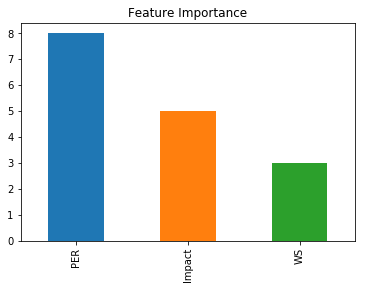

In [6]:
xgb_classt1 = XGBClassifier(learning_rate=2.8, n_estimators=500, max_depth=2, min_child_weight=6,
                                                objective='binary:logistic', subsample=0.5, colsample_by_tree = 0.6,
                                                nthread=4, scale_post_weight=1, seed=27, gamma=0, reg_alpha=0.01)



xgb_classt1.fit(X_train, y_train)

predictionst1 = xgb_classt1.predict(X_test)
predict_probat1 = xgb_classt1.predict_proba(X_test)

print("Accuracy : %.4g" % accuracy_score(y_test, predictionst1))
print("AUC Score : %f" % roc_auc_score(y_test, predict_probat1[:,1]))


print(confusion_matrix(y_test, predictionst1))
print(classification_report(y_test, predictionst1))
print('AUC Score', roc_auc_score(y_test, predict_probat1[:,1]))



print('Accuracy (I.e. Total Correct Predictions / Total Predictions)', (3228 + 57) / 3430)

params = {'learning_rate':2.8, 'scale_post_weight':1, 'min_child_weight':6, 'gamma':0, 'subsample':0.5, 
          'nthread':4, 'objective':'binary:logistic', 'n_estimators':500, 'seed':27, 'colsample_bytree':0.6,
          'max_depth':2, 'reg_alpha':0.01}

train = xgb.DMatrix(X_train, y_train)

cv_results = xgb.cv(dtrain=train, params=params, nfold=5, num_boost_round=50, early_stopping_rounds=10, metrics='auc',
                    as_pandas=True, seed=123)

print(cv_results)


feat_imp = pd.Series(xgb_classt1.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importance')

In [1280]:
# Lets try xgb with BBC
bbc_xgb = BalancedBaggingClassifier(base_estimator=XGBClassifier(learning_rate=0.09, n_estimators=265, max_depth=2, min_child_weight=6,
                                                objective='binary:logistic', subsample=0.8, colsample_by_tree = 0.75,
                                                nthread=4, scale_post_weight=1, seed=27, gamma=0, reg_alpha=0.1), 
                                sampling_strategy='auto', replacement=True, random_state=0)


bbc_xgb.fit(X_train, y_train)

predictionst1 = bbc_xgb.predict(X_test)
predict_probat1 = bbc_xgb.predict_proba(X_test)

print("Accuracy : %.4g" % accuracy_score(y_test, predictionst1))
print("AUC Score : %f" % roc_auc_score(y_test, predict_probat1[:,1]))


print(confusion_matrix(y_test, predictionst1))
print(classification_report(y_test, predictionst1))
print('AUC Score', roc_auc_score(y_test, predict_probat1[:,1]))

Accuracy : 0.9102
AUC Score : 0.968795
[[3026  298]
 [  10   96]]
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      3324
           1       0.24      0.91      0.38       106

   micro avg       0.91      0.91      0.91      3430
   macro avg       0.62      0.91      0.67      3430
weighted avg       0.97      0.91      0.93      3430

AUC Score 0.9687947006334718


In [375]:
# 'colsample_bytree': 0.6, 'n_estimators': 500, 'scale_post_weight': 0.0, 'subsample': 0.5

# Lets try xgb with BBC
bbc_xgb2 = BalancedBaggingClassifier(base_estimator=XGBClassifier(learning_rate=0.09, n_estimators=500, max_depth=2, min_child_weight=6,
                                                objective='binary:logistic', subsample=0.5, colsample_by_tree = 0.6,
                                                nthread=4, scale_post_weight=1, seed=27, gamma=0, reg_alpha=0.1), 
                                sampling_strategy='auto', replacement=True, random_state=0)


bbc_xgb2.fit(X_train, y_train)

predictionst2 = bbc_xgb2.predict(X_test)
predict_probat2 = bbc_xgb2.predict_proba(X_test)

print("Accuracy : %.4g" % accuracy_score(y_test, predictionst2))
print("AUC Score : %f" % roc_auc_score(y_test, predict_probat2[:,1]))


print(confusion_matrix(y_test, predictionst2))
print(classification_report(y_test, predictionst2))
print('AUC Score', roc_auc_score(y_test, predict_probat2[:,1]))

Accuracy : 0.912
AUC Score : 0.967902
[[3032  292]
 [  10   96]]
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      3324
           1       0.25      0.91      0.39       106

   micro avg       0.91      0.91      0.91      3430
   macro avg       0.62      0.91      0.67      3430
weighted avg       0.97      0.91      0.94      3430

AUC Score 0.9679021070317644


In [399]:
probability = pd.DataFrame(predict_probat2)
probability = probability.loc[:,1:]
probability.columns = ['Predicted MVP Probability']

predictions = pd.DataFrame(predictionst2)
predictions.columns = ['Predicted MVP']

real_mvp = pd.DataFrame(y_test)
real_mvp.columns = ['Real MVP']
real_mvp.reset_index(inplace=True)
real_mvp = real_mvp[['Real MVP']]

In [400]:
mvp_095_list = []
for proba in t_predictions['Predicted MVP Probability']:
    if proba >= 0.95:
        mvp_095_list.append(1)
    if proba < 0.95:
        mvp_095_list.append(0)
        
mvp_095_df = pd.DataFrame(mvp_095_list)
mvp_095_df.columns = ['MVP 0.95 Threshold']
mvp_095_df.reset_index(inplace=True)
mvp_095_df = mvp_095_df[['MVP 0.95 Threshold']]

In [401]:
mvp_090_list = []
for proba in t_predictions['Predicted MVP Probability']:
    if proba >= 0.90:
        mvp_090_list.append(1)
    if proba < 0.90:
        mvp_090_list.append(0)
        
mvp_090_df = pd.DataFrame(mvp_090_list)
mvp_090_df.columns = ['MVP 0.90 Threshold']
mvp_090_df.reset_index(inplace=True)
mvp_090_df = mvp_090_df[['MVP 0.90 Threshold']]

In [415]:
mvp_085_list = []
for proba in t_predictions['Predicted MVP Probability']:
    if proba >= 0.85:
        mvp_085_list.append(1)
    if proba < 0.85:
        mvp_085_list.append(0)
        
mvp_085_df = pd.DataFrame(mvp_085_list)
mvp_085_df.columns = ['MVP 0.85 Threshold']
mvp_085_df.reset_index(inplace=True)
mvp_085_df = mvp_085_df[['MVP 0.85 Threshold']]

In [402]:
predictors = pd.DataFrame(X_test)
predictors.reset_index(inplace=True)
predictors.columns = ['Player', 'WS', 'TS%', 'PPG', 'Impact', 'PER']
predictors.head(2)


,Player,WS,TS%,PPG,Impact,PER
0,3532,0.0,0.437,2.50,0.116034,1.5
1,272,1.9,0.498,14.34,355.519125,13.3


In [416]:
t_predictions = pd.concat([predictors, real_mvp, mvp_095_df, mvp_090_df, mvp_085_df, predictions, probability], axis=1)
t_predictions.head()

,Player,WS,TS%,PPG,Impact,PER,Real MVP,MVP 0.95 Threshold,MVP 0.90 Threshold,MVP 0.85 Threshold,Predicted MVP,Predicted MVP Probability
0,3532,0.00,0.4370,2.500,0.116034,1.50,0,0,0,0,0,0.028113
1,272,1.90,0.4980,14.340,355.519125,13.30,0,0,0,0,0,0.048747
2,12448,0.10,0.5240,0.000,0.241463,10.50,0,0,0,0,0,0.016289
3,825,0.50,0.4740,5.890,98.320280,13.00,0,0,0,0,0,0.028113
4,6359,0.65,0.4655,6.105,24.399957,13.35,0,0,0,0,0,0.028113


In [406]:
# Original - TN 96, FP 10, FN, 292, TP 3032

# At 0.95 Threshold - TN 57, FN 67, TP 3257, FP 49
# TN = 57 
TN095 = t_predictions[(t_predictions['MVP 0.95 Threshold'] == 1) &
              (t_predictions['Real MVP'] == 1)]

# FN = 67
FN095 = t_predictions[(t_predictions['MVP 0.95 Threshold'] == 1) &
              (t_predictions['Real MVP'] == 0)]

# TP = 3257
TP095 = t_predictions[(t_predictions['MVP 0.95 Threshold'] == 0) &
              (t_predictions['Real MVP'] == 0)]

# FP = 49
FP095 = t_predictions[(t_predictions['MVP 0.95 Threshold'] == 0) &
              (t_predictions['Real MVP'] == 1)]

print('Check :', len(TN095) + len(FN095) +len(TP095) + len(FP095))

Check : 3430


In [407]:
# At 0.90 Threshold, TN 71, FN 106, TP 3218, FP 35
# TN = 71
TN090 = t_predictions[(t_predictions['MVP 0.90 Threshold'] == 1) &
              (t_predictions['Real MVP'] == 1)]

# FN = 106
FN090 = t_predictions[(t_predictions['MVP 0.90 Threshold'] == 1) &
              (t_predictions['Real MVP'] == 0)]

# TP = 3218
TP090 = t_predictions[(t_predictions['MVP 0.90 Threshold'] == 0) &
              (t_predictions['Real MVP'] == 0)]

# FP = 35
FP090 = t_predictions[(t_predictions['MVP 0.90 Threshold'] == 0) &
              (t_predictions['Real MVP'] == 1)]

print('Check :', len(TN090) + len(FN090) +len(TP090) + len(FP090))

Check : 3430


In [417]:
# At 0.85 Threshold, TN 71, FN 106, TP 3218, FP 35
# TN = 80
TN085 = t_predictions[(t_predictions['MVP 0.85 Threshold'] == 1) &
              (t_predictions['Real MVP'] == 1)]

# FN = 139
FN085 = t_predictions[(t_predictions['MVP 0.85 Threshold'] == 1) &
              (t_predictions['Real MVP'] == 0)]

# TP = 3185
TP085 = t_predictions[(t_predictions['MVP 0.85 Threshold'] == 0) &
              (t_predictions['Real MVP'] == 0)]

# FP = 26
FP085 = t_predictions[(t_predictions['MVP 0.85 Threshold'] == 0) &
              (t_predictions['Real MVP'] == 1)]

print('Check :', len(TN085) + len(FN085) +len(TP085) + len(FP085))

Check : 3430


In [421]:
FP085.shape

(26, 12)

In [394]:
t_predictions[(t_predictions['MVP 0.95 Threshold'] == 0) &
              (t_predictions['Real MVP'] == 1)].shape

(49, 10)

In [371]:
# 0.9 True Negatives, where Predicted and Real = 1 and Proba >= 0.95
#TN09 = t_predictions[(t_predictions['Real MVP'] == 1) & 
#                      (t_predictions['Predicted MVP'] == 1) & 
#                      (t_predictions['Predicted MVP Probability'] >= 0.95)]

# Real = 1, Proba <=0.94 is essentially 0
# 0.9 False Positives, where Predicted = 0, Real = 1 OR
# (Real = 1, but Proba <= 0.94) Predicted = 1
#FP09_a = t_predictions[(t_predictions['Real MVP'] == 1) & 
#                      (t_predictions['Predicted MVP'] == 1) & 
#                      (t_predictions['Predicted MVP Probability'] < 0.95)]

#FP09_b = t_predictions[(t_predictions['Predicted MVP'] == 0) & 
#                       (t_predictions['Real MVP'] == 1)]


# 0.9 True Positives, where Real = 0, Predict = 0 
#TP09 = t_predictions[(t_predictions['Predicted MVP'] == 0) & 
#                       (t_predictions['Real MVP'] == 0)]



# False Negatives, where Predict = 1, Real = 0 (Not a real MVP)
#FN09_a = t_predictions[(t_predictions['Real MVP'] == 0) & 
#                      (t_predictions['Predicted MVP'] == 1) & 
#                      (t_predictions['Predicted MVP Probability'] >= 0.95)]

#FN09_b = t_predictions[(t_predictions['Predicted MVP'] == 1) & 
#                       (t_predictions['Real MVP'] == 0) &
#                       (t_predictions['Predicted MVP Probability'] < 0.95)]




#TotalMVP_09 = t_predictions[(t_predictions['Real MVP'] ==1) & (t_predictions['Predicted MVP Probability'] >= 0.95)]
#TotalRealMVP = t_predictions[t_predictions['Real MVP'] == 1]
#TotalNotMVP = t_predictions[t_predictions['Real MVP'] == 0]


#ModelTN = t_predictions[(t_predictions['Predicted MVP'] == 1) & (t_predictions['Real MVP'] == 1)]
#ModelFN = t_predictions[(t_predictions['Predicted MVP'] == 1) & (t_predictions['Real MVP'] == 0)]
#ModelFP = t_predictions[(t_predictions['Predicted MVP'] == 0) & (t_predictions['Real MVP'] == 1)]
#ModelTP = t_predictions[(t_predictions['Predicted MVP'] == 0) & (t_predictions['Real MVP'] == 0)]

In [369]:
# At 0.9 threshold:
# ALl MVPs are corrected predicted, there are 0 FPs, 
# FP - Predicted wrongly is 0
# TN - Predicted correctly is 71
# FN - FN is 106 (Meaning 106 people who are not MVPs are predicted as MVPs)

#print('Total Number of MVPs within the Test Set :', len(TotalRealMVP))
#print('Total Number of non-MVPs within the Test Set :', len(TotalNotMVP))

#print('---------------------------------------------------------------------------')

#print('Model TN (Real MVP, Predicted MVP) : ', len(ModelTN))
#print('Model FP (Real MVP, Predicted Non-MVP) :', len(ModelFP))
#print('Model FN (Not MVP, Predicted MVP) :', len(ModelFN))
#print('Model TP (Not MVP, Predicted Non-MVP) :', len(ModelTP))
#print('Check :', len(ModelTN) + len(ModelFP) + len(ModelFN) + len(ModelTP))

#print('---------------------------------------------------------------------------')

#print('0.9 Threshold TN (Real MVP, Predicted MVP) :', len(TN09))
#print('0.9 Threshold FP (Real MVP, Predicted Non-MVP) :', (len(FP09_a) + len(FP09_b)))
#print('0.9 Threshold FN (Not MVP, Predicted MVP) :', len(FN09_a) + len(FN09_b))
#print('0.9 Threshold TP (Not MVP, Predicted Non-MVP) :', len(TP09))
#print('Check :', len(TN09) + (len(FP09_a) + len(FP09_b)) + len(FN09_a) + len(FN09_b) + len(TP09))

